# Sentiment Analysis - Spanish Movie Reviews
**By Zach Friedman**, zacheryfriedman@my.unt.edu

In [123]:
import pandas as pd
import nltk
import numpy as np

# NLTK VADER imports
from nltk.tokenize import WordPunctTokenizer, sent_tokenize
from nltk.corpus import sentiwordnet as swn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
# MultinomialNB imports
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /home/zach/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/zach/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/zach/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/zach/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/zach/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/zach/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Preliminary Model: VADER Sentiment Analysis Tool
> https://github.com/cjhutto/vaderSentiment

In [79]:
df = pd.read_csv('./sanitized_v2.csv')

In [80]:
def analyze(doc):
    sia = SentimentIntensityAnalyzer()
    #doc = " ".join(doc)
    #sentiment = sia.polarity_scores(doc)
    return sia.polarity_scores(doc)

def sentence_tokenizer(doc):
    sentences = sent_tokenize(doc)
    #lemmatizer = WordNetLemmatizer()
    
    sentences = [[word.lower() for word in sent.split() if word not in stopwords.words('english')] for sent in sentences]
    
    return [" ".join(sent) for sent in sentences]

In [81]:
df['review_en'] = df['review_en'].apply(sentence_tokenizer) # Apply sentence tokenization to each English review in the dataframe

In [82]:
labels = [] # A list to hold the predicted labels for each review

for i in range(len(df)): # For each review in the dataframe...
    review_sentiment = [] # A list to hold the sentiments of each sentence in a review

    for sent in df['review_en'].iloc()[i]: # For each sentence in a review...

        analysis = analyze(sent) # Apply the sentiment intensity analyzer to each sentence

        subset = ['neg', 'pos'] # We only care about the negative and positive scores, since the dataset does not include neutral labels
        subset_dict = {key: value for key, value in analysis.items() if key in subset} # Create a subset dictionary with 'neg' and 'pos' key-value pairs

        sentiment = max(subset_dict, key=subset_dict.get) # Get the maximum of the 'neg' and 'pos' scores

        review_sentiment.append(sentiment) # Append the sentiment for the current sentence to the list of sentiments

    sentiment_counts = Counter(review_sentiment) # Count the number of 'neg' and 'pos' in the list of sentiments

    # Find the most common sentiment in the list of sentiments for a review and append the appropriate label to the list of prediction labels
    if sentiment_counts.most_common(1)[0][0] == 'neg':
        labels.append('negative')
    else:
        labels.append('positive')

predictions = pd.DataFrame(data=labels, columns=["prediction"])

predictions

,prediction
0,negative
1,positive
2,positive
3,negative
4,positive
...,...
49995,positive
49996,positive
49997,negative
49998,negative


In [83]:
predictions.to_csv("predictions_v2.csv")

In [115]:
merged = pd.merge(df['sentiment'], predictions['prediction'], left_index=True, right_index=True)

boolean_mask = merged.iloc[:,0] == merged.iloc[:,1]

vader_accuracy = boolean_mask.mean()

print(f"VADER accuracy: {vader_accuracy}")

VADER accuracy: 0.68998


## Multinomial Naive Bayes

In [85]:
fresh_df = pd.read_csv('./sanitized_v2.csv')

fresh_df = fresh_df.drop(['Unnamed: 0'], 1)
fresh_df = fresh_df.drop(['review_es'], 1)
fresh_df = fresh_df.drop(['sentimiento'], 1)

/tmp/ipykernel_8856/1248093981.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['Unnamed: 0'], 1)
/tmp/ipykernel_8856/1248093981.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['review_es'], 1)
/tmp/ipykernel_8856/1248093981.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  fresh_df = fresh_df.drop(['sentimiento'], 1)


In [99]:
fresh_df.to_csv("sanitized_v2.csv")

In [124]:
X = fresh_df.iloc[:, :-1]
y = fresh_df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80/20 split

X_train = X_train['review_en'].tolist() # Convert English reviews in X_train to a list of strings
X_test = X_test['review_en'].tolist() # Convert reviews in X_test to a list of strings

vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [127]:
nb = MultinomialNB() # Instantiate a Multinomial Naive Bayes classifier object

nb.fit(X_train, y_train) # Fit the classifier to the object

yhat = nb.predict(X_test) # Create a set of predictions on the test set

nb_accuracy = accuracy_score(y_test, yhat) # Generate an accuracy score based on the ground truth 'y_test' and the list of predictions 'yhat'

In [128]:
print(f"MultinomialNB accuracy: {nb_accuracy}")

MultinomialNB accuracy: 0.8633


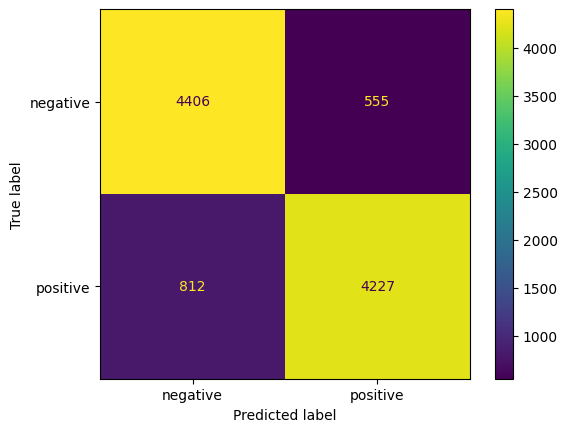

In [129]:
cm = confusion_matrix(y_test, yhat)

cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'positive']) # Create a prettier version of the confusion matrix. 

cm_display.plot()

In [130]:
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

    negative       0.84      0.89      0.87      4961
    positive       0.88      0.84      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

